# Energy Portfolio Optimization for Switzerland

This notebook implements a comprehensive energy portfolio optimization framework with modular, reusable components.

## Structure:
- **Section 0**: Setup (imports, data loading, scenario selection)
- **Section 1**: Dispatch Simulation (test portfolios)
- **Section 2**: Genetic Optimizer (Pareto frontier search)
- **Section 3**: Analysis (3D visualization, efficiency analysis, individual portfolios)

## Key Features:
- **Single scenario selection**: Choose 2024 or 2050 at setup
- **Encapsulated functions**: Reusable helper functions avoid code duplication
- **Modular design**: Each section can run independently after setup
- **Comprehensive analysis**: Energy flows, efficiency metrics, and visualizations

---


## Section 0: Setup

### 0.1 Imports


In [10]:
# =============================================================================
# IMPORTS - Run this cell first
# =============================================================================

# Standard library
import os
import sys
import json
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional, Any

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D

# Progress tracking
from tqdm.notebook import tqdm

# Interactive widgets
try:
    import ipywidgets as widgets
    from ipywidgets import Dropdown, Button, Output, VBox, HBox, Layout, Label, IntSlider
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False
    print("⚠️ ipywidgets not installed. Run: pip install ipywidgets")

# Suppress warnings
warnings.filterwarnings('ignore')

# =============================================================================
# RELOAD MODULES - Run this to reload all project modules without restarting kernel
# =============================================================================
import importlib

# Reload all project-specific modules
importlib.reload(sys.modules.get('config', importlib.import_module('config')))
importlib.reload(sys.modules.get('data_loader', importlib.import_module('data_loader')))
importlib.reload(sys.modules.get('ppu_framework', importlib.import_module('ppu_framework')))
importlib.reload(sys.modules.get('dispatch_engine', importlib.import_module('dispatch_engine')))
importlib.reload(sys.modules.get('optimization', importlib.import_module('optimization')))
importlib.reload(sys.modules.get('portfolio_metrics', importlib.import_module('portfolio_metrics')))
importlib.reload(sys.modules.get('risk_calculator', importlib.import_module('risk_calculator')))
importlib.reload(sys.modules.get('multi_objective_explorer', importlib.import_module('multi_objective_explorer')))
importlib.reload(sys.modules.get('pareto_frontier', importlib.import_module('pareto_frontier')))
importlib.reload(sys.modules.get('visualization', importlib.import_module('visualization')))
importlib.reload(sys.modules.get('frontier_research', importlib.import_module('frontier_research')))

# Re-import after reload
from config import Config, DEFAULT_CONFIG
from data_loader import load_all_data, CachedData
from ppu_framework import (
    load_all_ppu_data, Portfolio, create_ppu_dictionary,
    estimate_annual_production, check_energy_sovereignty
)
from dispatch_engine import (
    run_dispatch_simulation, initialize_storage_state,
    compute_scenario_cost
)
from optimization import (
    evaluate_portfolio_full_year, Individual,
    run_genetic_algorithm, FullYearResults
)
from portfolio_metrics import (
    PortfolioMetrics3D, calculate_portfolio_metrics_3d
)
from risk_calculator import RiskCalculator
from multi_objective_explorer import (
    MultiObjectiveGA, ObjectiveConfig,
    explore_and_find_frontier, continue_exploration_3d_frontier
)
from pareto_frontier import (
    find_and_plot_efficiency_frontier,
    load_frontier_from_csv,
    plot_efficiency_frontier,
    extract_pareto_frontier_from_df
)
from visualization import (
    plot_fitness_evolution, plot_portfolio_composition,
    plot_dispatch_scenario, create_optimization_dashboard,
    plot_demand_volatility, plot_spot_price_volatility,
    plot_energy_balance_distribution, plot_full_year_overview,
    plot_full_year_storage, plot_full_year_production_by_source
)
from frontier_research import (
    run_frontier_research, FrontierResearchConfig, FrontierResearchResults
)

# Import notebook helpers
import notebook_helpers

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Create output directories
os.makedirs('data/result_plots', exist_ok=True)

print("✅ All imports successful!")
print(f"   Config loaded: {type(DEFAULT_CONFIG).__name__}")
print(f"   Widgets available: {HAS_WIDGETS}")
print("   🔄 Modules reloaded - changes will take effect immediately")


✅ All imports successful!
   Config loaded: Config
   Widgets available: True
   🔄 Modules reloaded - changes will take effect immediately


### 0.2 Setup Simulation: Choose Scenario and Load Data


In [11]:
# =============================================================================
# SCENARIO SELECTION: Choose 2024 or 2050
# =============================================================================
# - "2024": Base demand curve (113 TWh total, 23 TWh aviation)
# - "2050": 1.6× growth scenario (~181 TWh total, ~37 TWh aviation)

DEMAND_SCENARIO = "2024"  # ← CHANGE THIS TO "2050" FOR FUTURE SCENARIO

# Create config with selected scenario
config = Config()
config.energy_system.DEMAND_SCENARIO = DEMAND_SCENARIO

# Load data with the selected scenario
print(f"📊 Loading data for {DEMAND_SCENARIO} scenario...")
cached_data = load_all_data(config, force_reload=True)
ppu_definitions, ppu_order, _ = load_all_ppu_data(config)

print(f"\n✅ Setup complete!")
print(f"   Scenario: {DEMAND_SCENARIO}")
print(f"   Demand multiplier: {config.energy_system.DEMAND_MULTIPLIER}x")
print(f"   Target demand: {config.energy_system.TARGET_ANNUAL_DEMAND_TWH:.1f} TWh/year")
print(f"   Aviation fuel: {config.energy_system.AVIATION_FUEL_DEMAND_TWH_YEAR:.1f} TWh/year")
print(f"   Data loaded: {len(cached_data.get_demand())} hours")


📊 Loading data for 2024 scenario...
Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind data loaded (mean: 1.3 m/s, no scaling)
  - Wind incidence: (9072, 1150)
  - Spot prices (EUR): (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded (LCOE: 26 PPUs)
  - EUR/CHF rates: 366 days
  - Palm oil prices (CHF/MWh): 366 days, avg 100.79
  - Water inflow: 8784 hours, total 42.74 TWh
  - Spot prices converted to CHF: avg 72.07 CHF/MWh
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete! (Demand scenario: 2024, multiplier: 1.0x)

✅ Setup complete!
   Scenario: 2024
   Demand multiplier: 1.0x
   Target demand: 113.0 TWh/year
   Aviation fuel: 23.0 TWh/year
   Data loaded: 8784 hours


### 0.3 External Data Overview


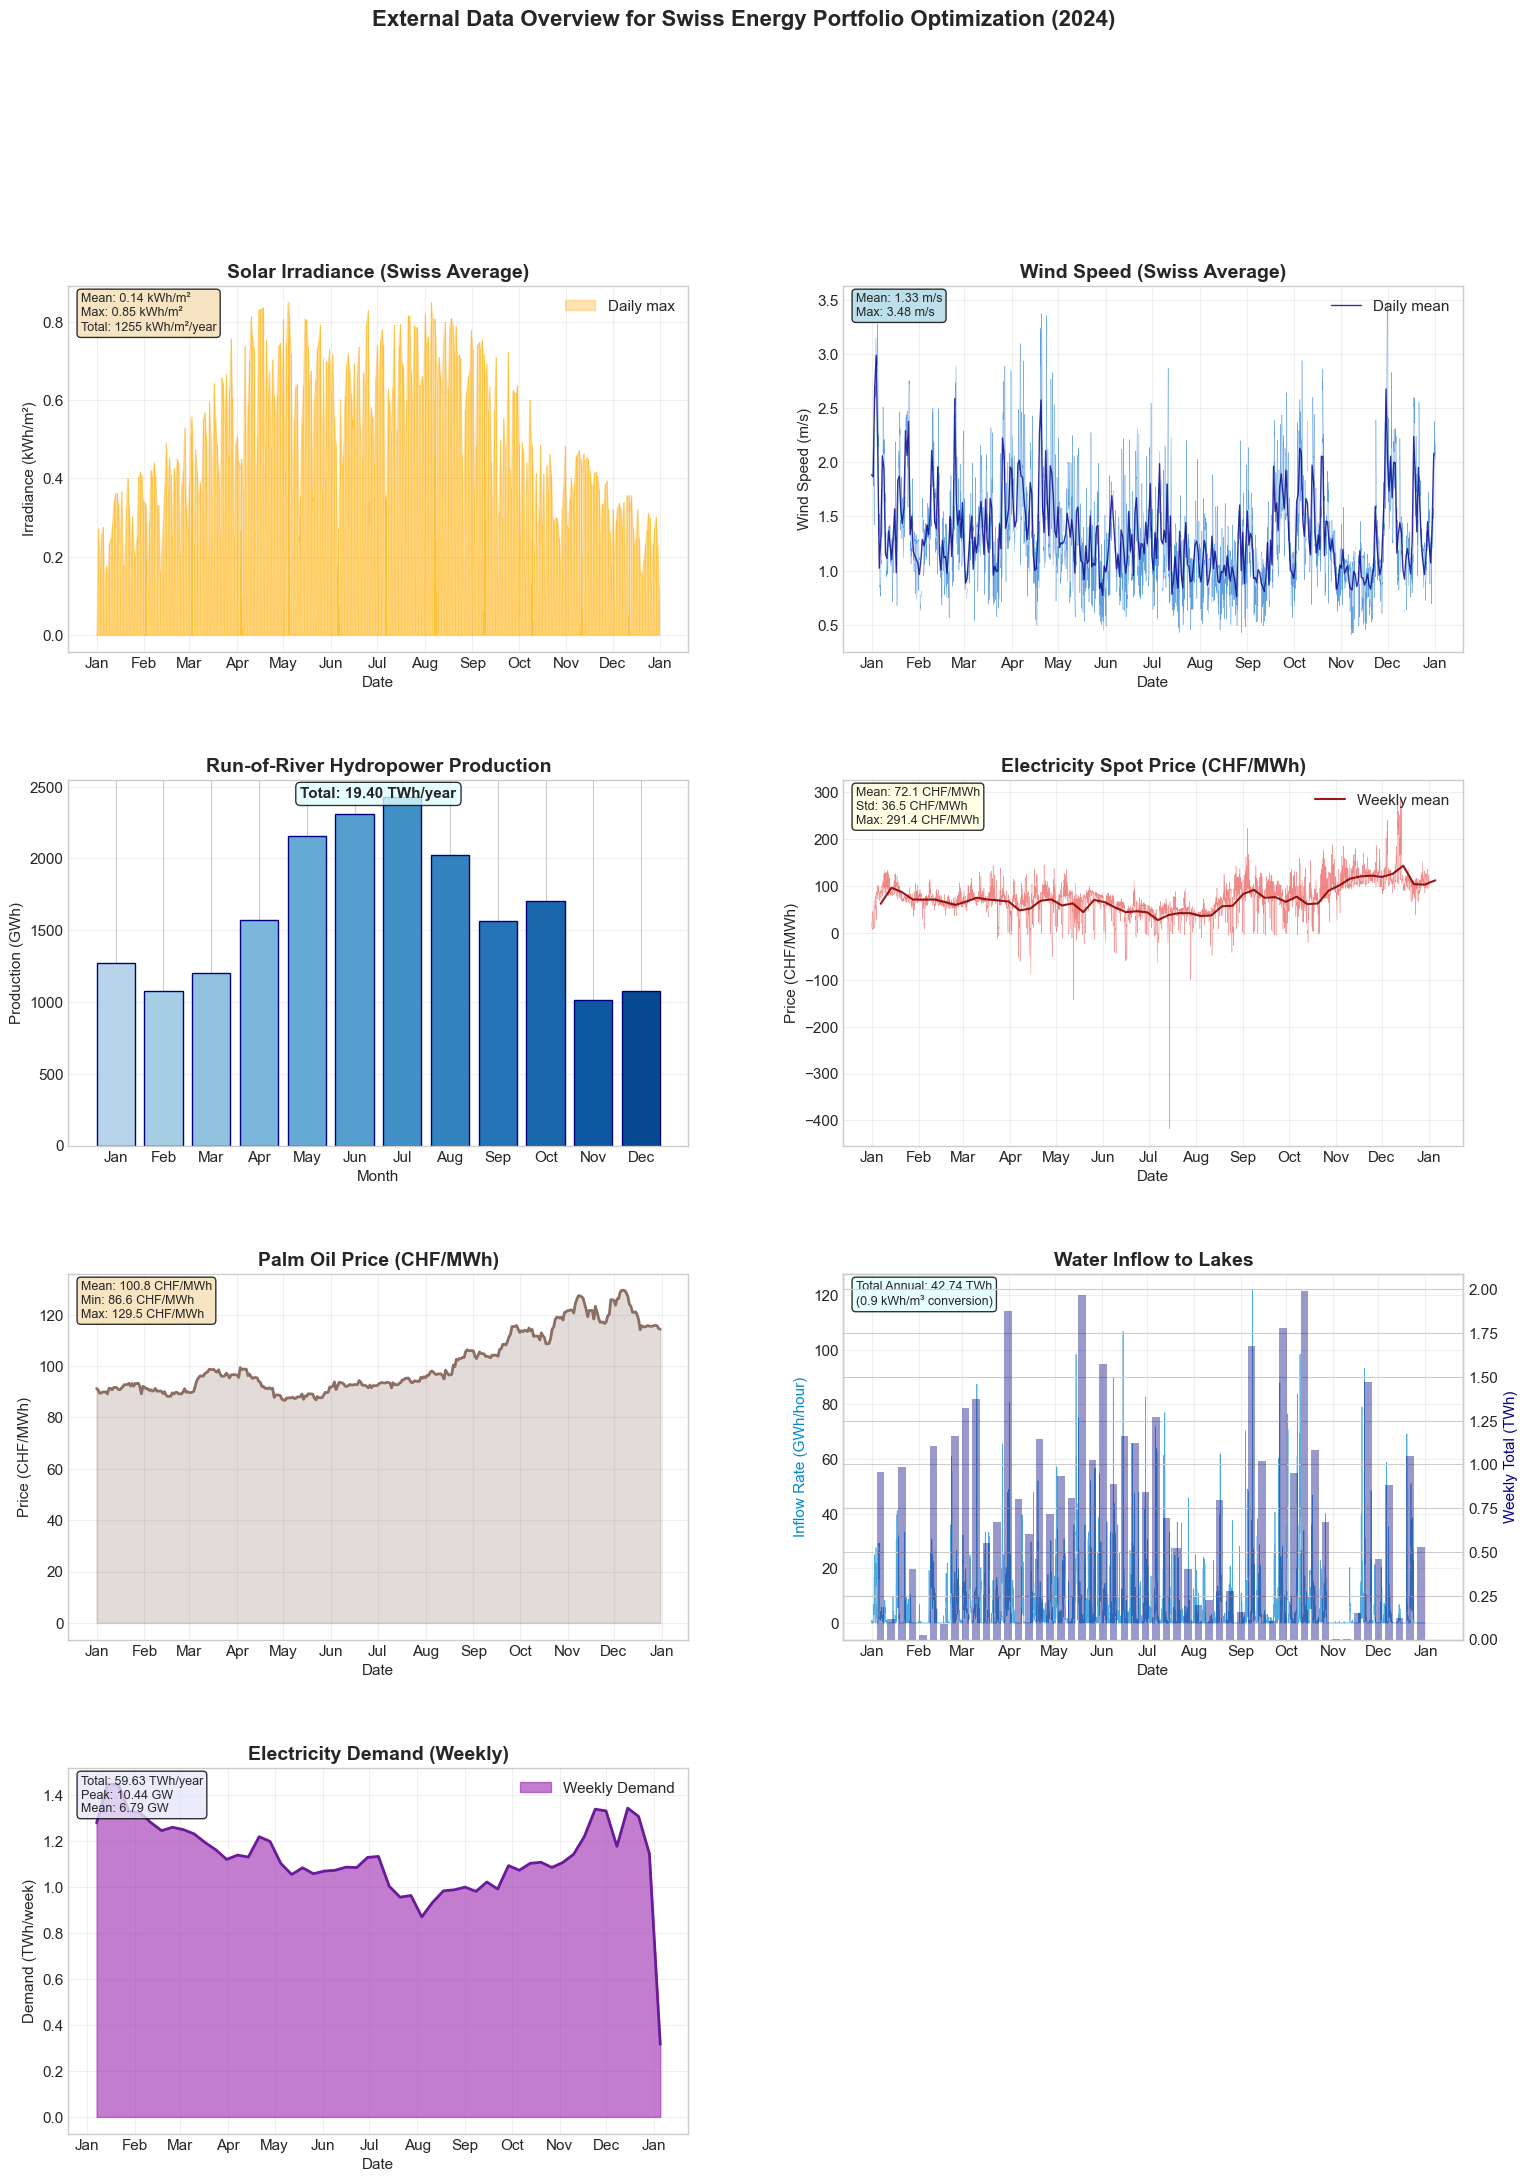

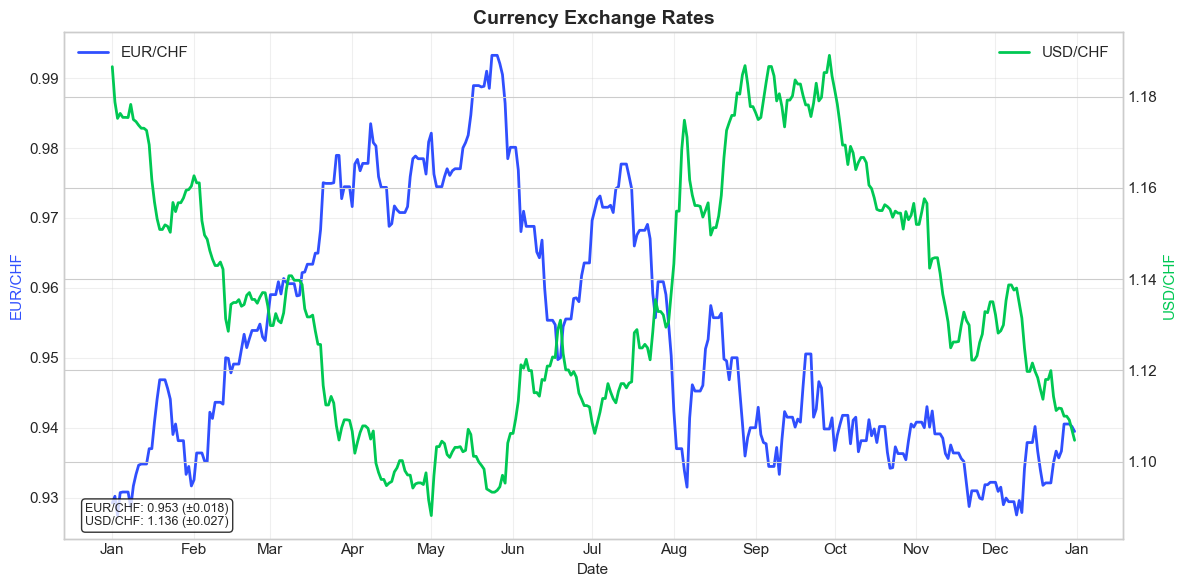


✅ External data overview saved to: data/result_plots/external_data_overview.png


In [12]:
# =============================================================================
# EXTERNAL DATA OVERVIEW - Visualization of all input data (Encapsulated)
# =============================================================================
# Note: Currency exchange rates are plotted separately below

# Plot external data overview (all except currency exchange rates)
fig = notebook_helpers.plot_external_data_overview(
    cached_data=cached_data,
    demand_scenario=DEMAND_SCENARIO,
    save_path='data/result_plots/external_data_overview.png'
)
plt.show()

# Plot Currency Exchange Rates separately
n_hours = len(cached_data.get_demand())
days = pd.date_range('2024-01-01', periods=366, freq='D')
eur_chf = cached_data.eur_chf_daily
usd_chf = cached_data.usd_chf_daily

fig_currency, ax7 = plt.subplots(figsize=(12, 6))
ax7.plot(days[:len(eur_chf)], eur_chf, color='#304FFE', linewidth=2, label='EUR/CHF')
ax7_twin = ax7.twinx()
ax7_twin.plot(days[:len(usd_chf)], usd_chf, color='#00C853', linewidth=2, label='USD/CHF')
ax7.set_title('Currency Exchange Rates', fontsize=14, fontweight='bold')
ax7.set_xlabel('Date')
ax7.set_ylabel('EUR/CHF', color='#304FFE')
ax7_twin.set_ylabel('USD/CHF', color='#00C853')
ax7.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax7.xaxis.set_major_locator(mdates.MonthLocator())
ax7.legend(loc='upper left')
ax7_twin.legend(loc='upper right')
ax7.grid(True, alpha=0.3)
stats_text = f"EUR/CHF: {np.mean(eur_chf):.3f} (±{np.std(eur_chf):.3f})\nUSD/CHF: {np.mean(usd_chf):.3f} (±{np.std(usd_chf):.3f})"
ax7.text(0.02, 0.02, stats_text, transform=ax7.transAxes, fontsize=9, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

print(f"\n✅ External data overview saved to: data/result_plots/external_data_overview.png")


### 0.4 Correlation Analysis with Demand


📊 Calculating rolling correlations with demand...
   Using Pearson correlation (scale-invariant, no normalization needed)


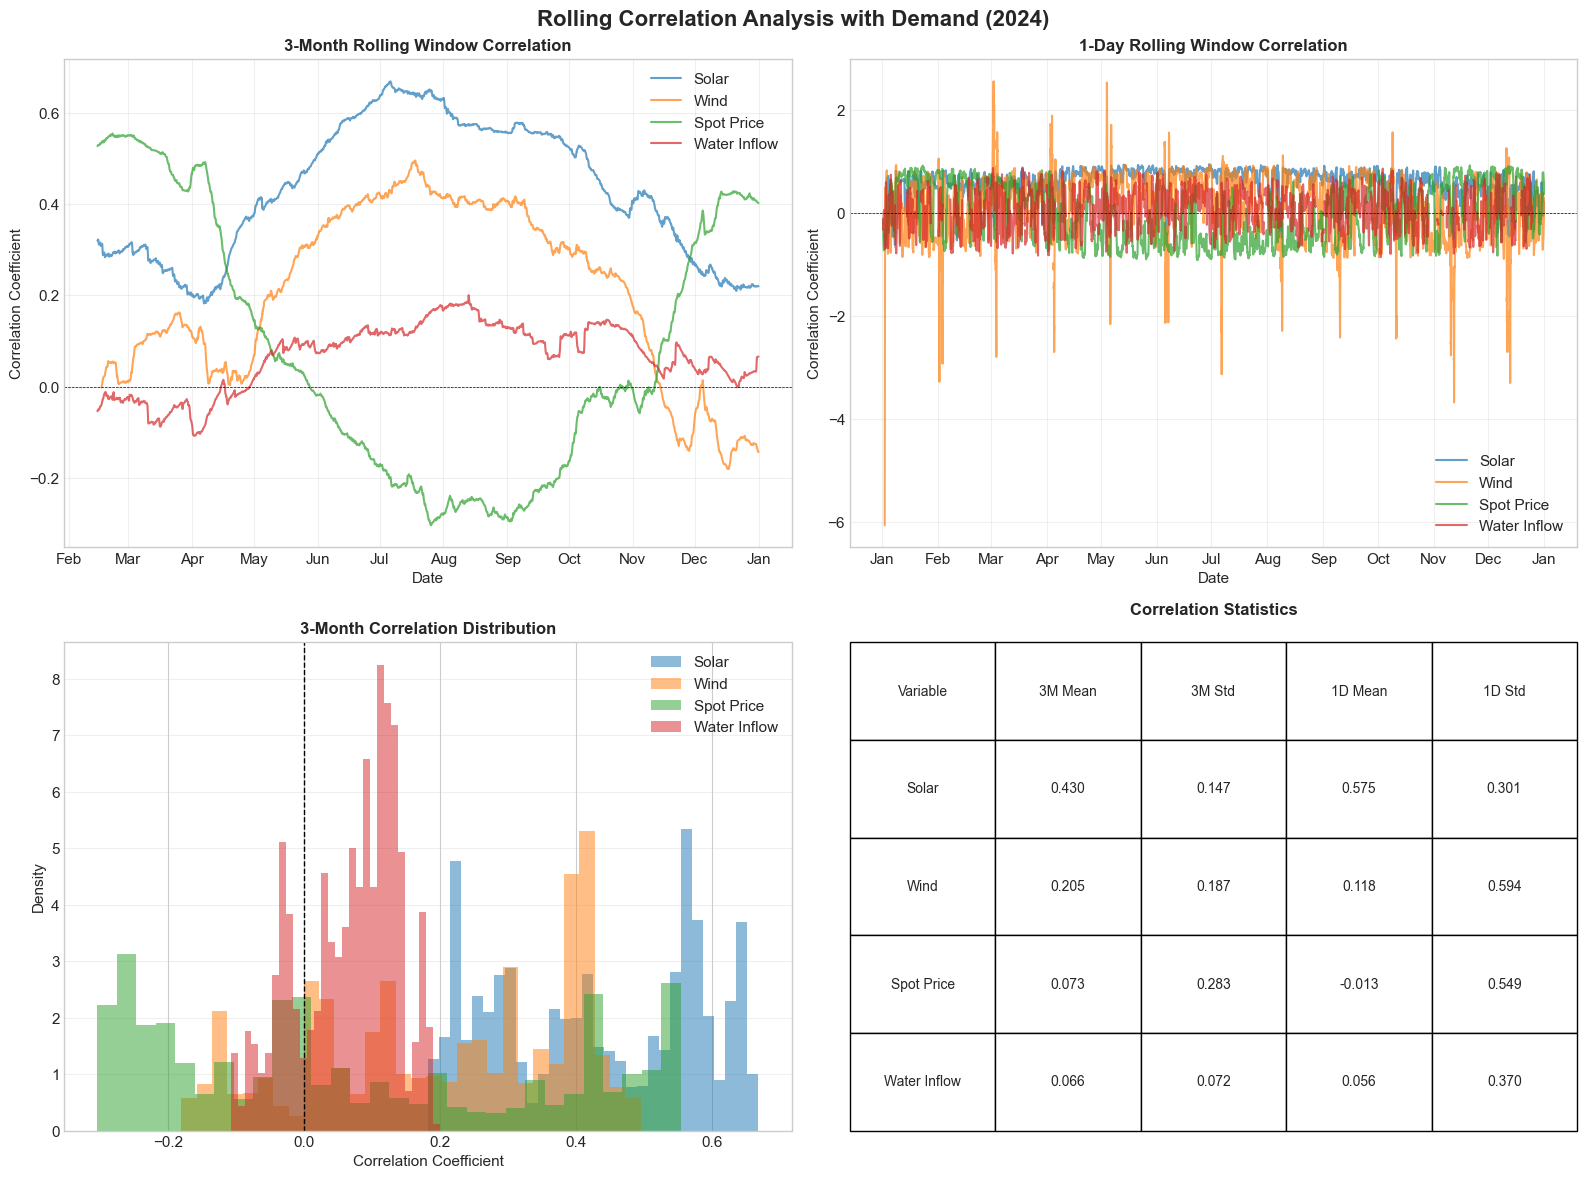


DIAGNOSTIC: Why 'Seasonal' Correlation is Positive Despite Negative Seasonal Alignment?

🔍 TRUE SEASONAL CORRELATION (Across Seasons):
----------------------------------------------------------------------
  This measures: Do months with HIGH solar have HIGH demand?
  Expected: NEGATIVE (summer = high solar, low demand)
  Note: Using Pearson correlation (scale-invariant, no normalization needed)

  Monthly averages correlation (12 data points, one per month):
    Solar               :  -0.825
    Wind                :   0.629
    Spot Price          :   0.548
    Water Inflow        :  -0.234

  Monthly averages:
    Month    |      Solar |  Demand (GW) |    Ratio
    ---------------------------------------------
    Jan      |      0.058 |         8.16 |    0.007
    Feb      |      0.084 |         7.55 |    0.011
    Mar      |      0.130 |         7.02 |    0.019
    Apr      |      0.192 |         6.94 |    0.028
    May      |      0.202 |         6.38 |    0.032
    Jun      |  

In [ ]:
# =============================================================================
# CORRELATION ANALYSIS WITH DEMAND
# =============================================================================
# Two key correlation metrics:
# - Seasonal: Monthly averages correlation (removes diurnal effects)
# - Hourly: Mean correlation at each hour of day (day-to-day variation)

print("📊 Computing correlation analysis with demand...")

# Compute correlations using encapsulated functions
seasonal_corr = notebook_helpers.compute_seasonal_correlation(cached_data)
hourly_corr = notebook_helpers.compute_hourly_correlation(cached_data)
monthly_avg = notebook_helpers.get_monthly_averages(cached_data)

# Display results
print("\n" + "=" * 70)
print("CORRELATION ANALYSIS RESULTS")
print("=" * 70)

print("\n📅 SEASONAL CORRELATION (Monthly Averages):")
print("-" * 70)
print("  Measures alignment between monthly averages of each variable and demand.")
print("  Negative = seasonal mismatch (high solar in summer when demand is low)")
print("")
print(f"  {'Variable':<20} | {'Correlation':>12}")
print("  " + "-" * 35)
for var, corr_val in seasonal_corr.items():
    print(f"  {var.replace('_', ' ').title():<20} | {corr_val:>12.3f}")

print("\n⏰ HOURLY CORRELATION (Mean across hours of day):")
print("-" * 70)
print("  Measures day-to-day correlation at the same hour (e.g., all 12:00 values).")
print("  Near zero = no consistent relationship across days at same hour")
print("")
print(f"  {'Variable':<20} | {'Correlation':>12}")
print("  " + "-" * 35)
for var, corr_val in hourly_corr.items():
    print(f"  {var.replace('_', ' ').title():<20} | {corr_val:>12.3f}")

# Monthly averages table
print("\n📊 MONTHLY AVERAGES:")
print("-" * 70)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
print(f"  {'Month':<8} | {'Solar (kWh/m²)':>14} | {'Demand (GW)':>12} | {'Wind (m/s)':>11}")
print("  " + "-" * 52)
for i, month in enumerate(monthly_avg.index):
    solar_val = monthly_avg.loc[month, 'solar']
    demand_val = monthly_avg.loc[month, 'demand'] / 1000
    wind_val = monthly_avg.loc[month, 'wind']
    print(f"  {month_names[i]:<8} | {solar_val:>14.3f} | {demand_val:>12.2f} | {wind_val:>11.2f}")

print("\n✅ Correlation analysis complete")


## Section 1: Dispatch Simulation

### 1.1 Create and Test Your Own Portfolio


Test Portfolio Configuration:
Total PPU units: 10500
  Renewable: 600 units
  Storage Input: 7800 units
  Storage Extraction: 2100 units

🔍 CONSTRAINT COMPLIANCE CHECK:
------------------------------------------------------------
✅ Aviation Fuel: PASS
   - THERM: 1000 (≥263 required)
   - SYN_FT: 2000, SYN_CRACK: 2000
⏳ Electrical Sovereignty (≥113 TWh/year): Check after simulation
⏳ Cyclic SOC (storage returns to initial): Check after simulation
------------------------------------------------------------

⏳ Running full-year dispatch simulation (8,760 hours)...
   This may take 30-60 seconds...
✅ Simulation complete!

📊 Generating visualizations...
Saved: data/result_plots/dispatch_production_stack.png


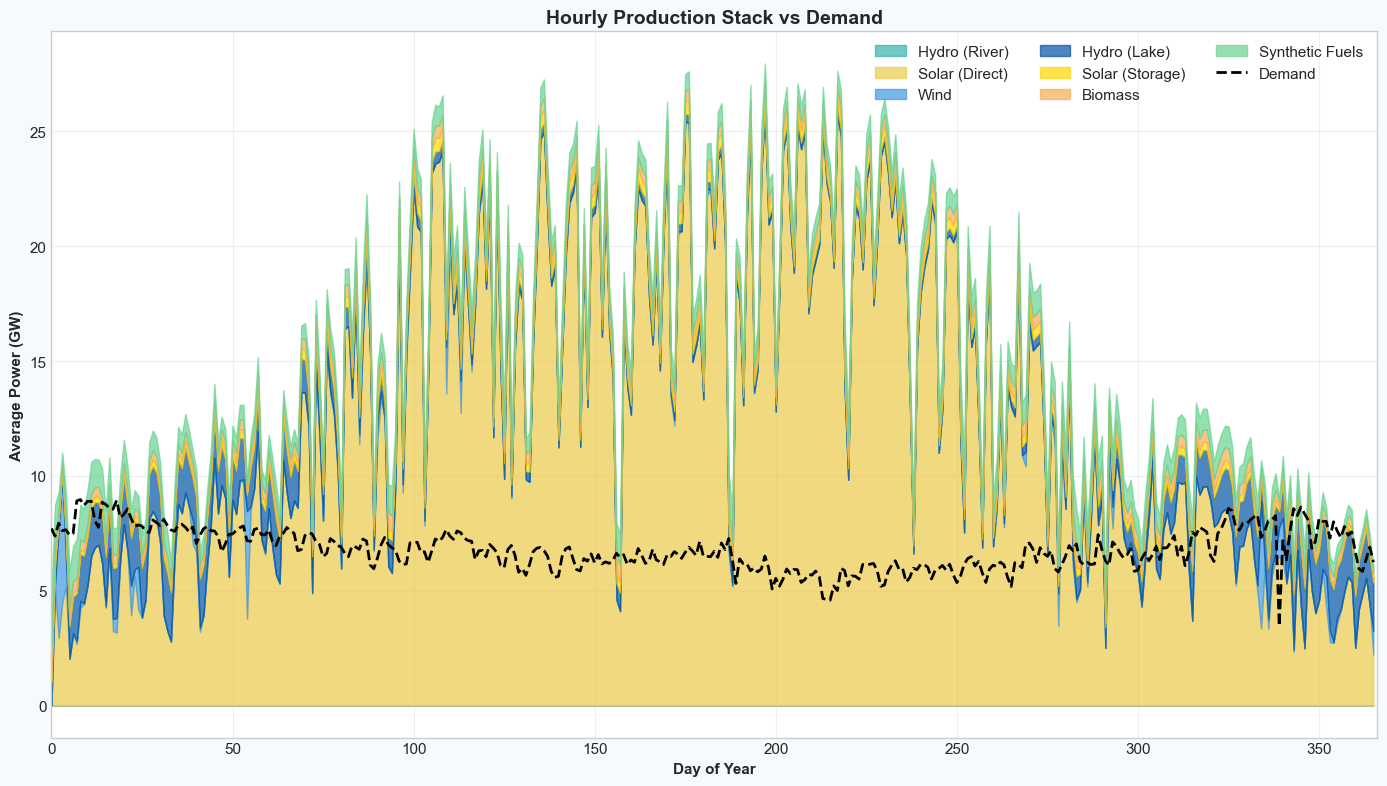

Saved: data/result_plots/dispatch_storage_soc.png


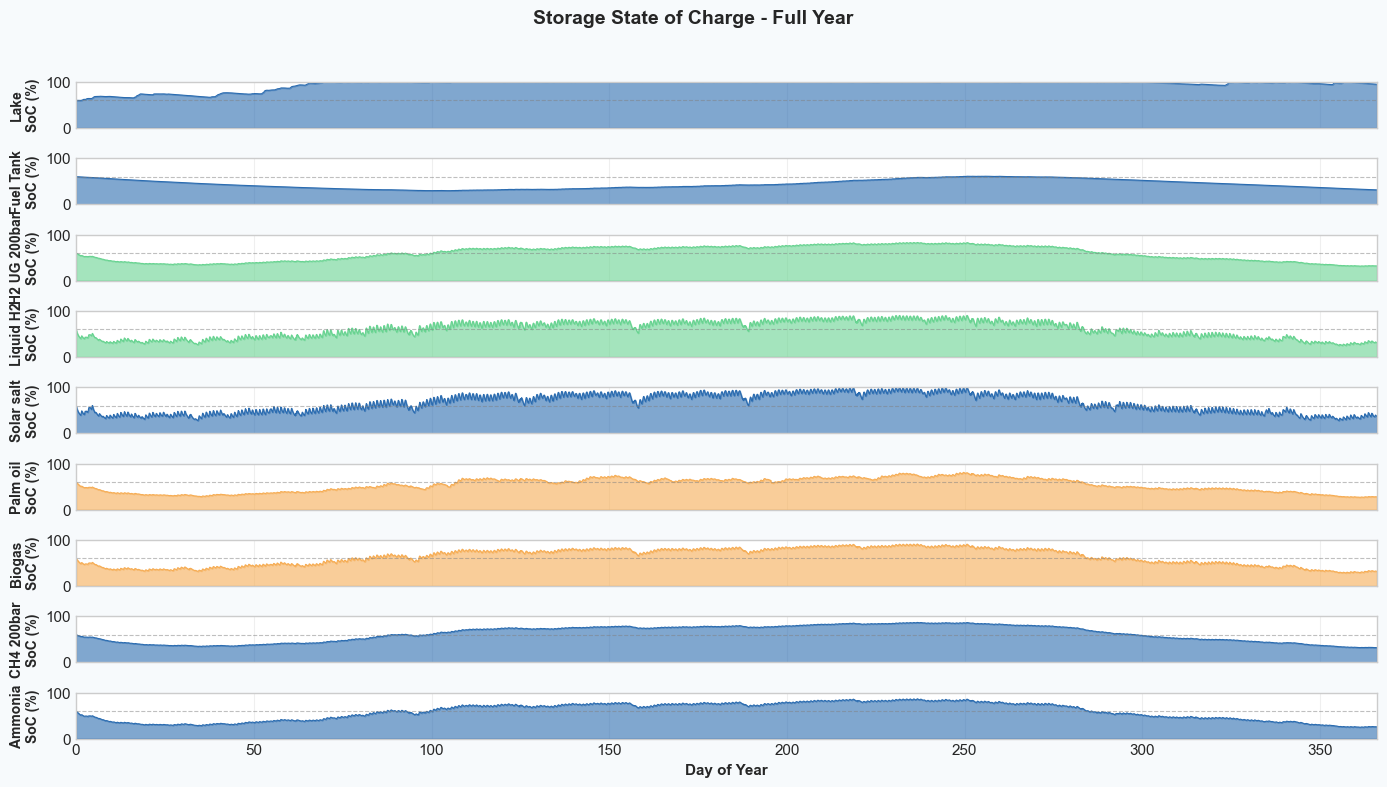

Saved energy balance distribution plot: data/result_plots/dispatch_energy_balance.png


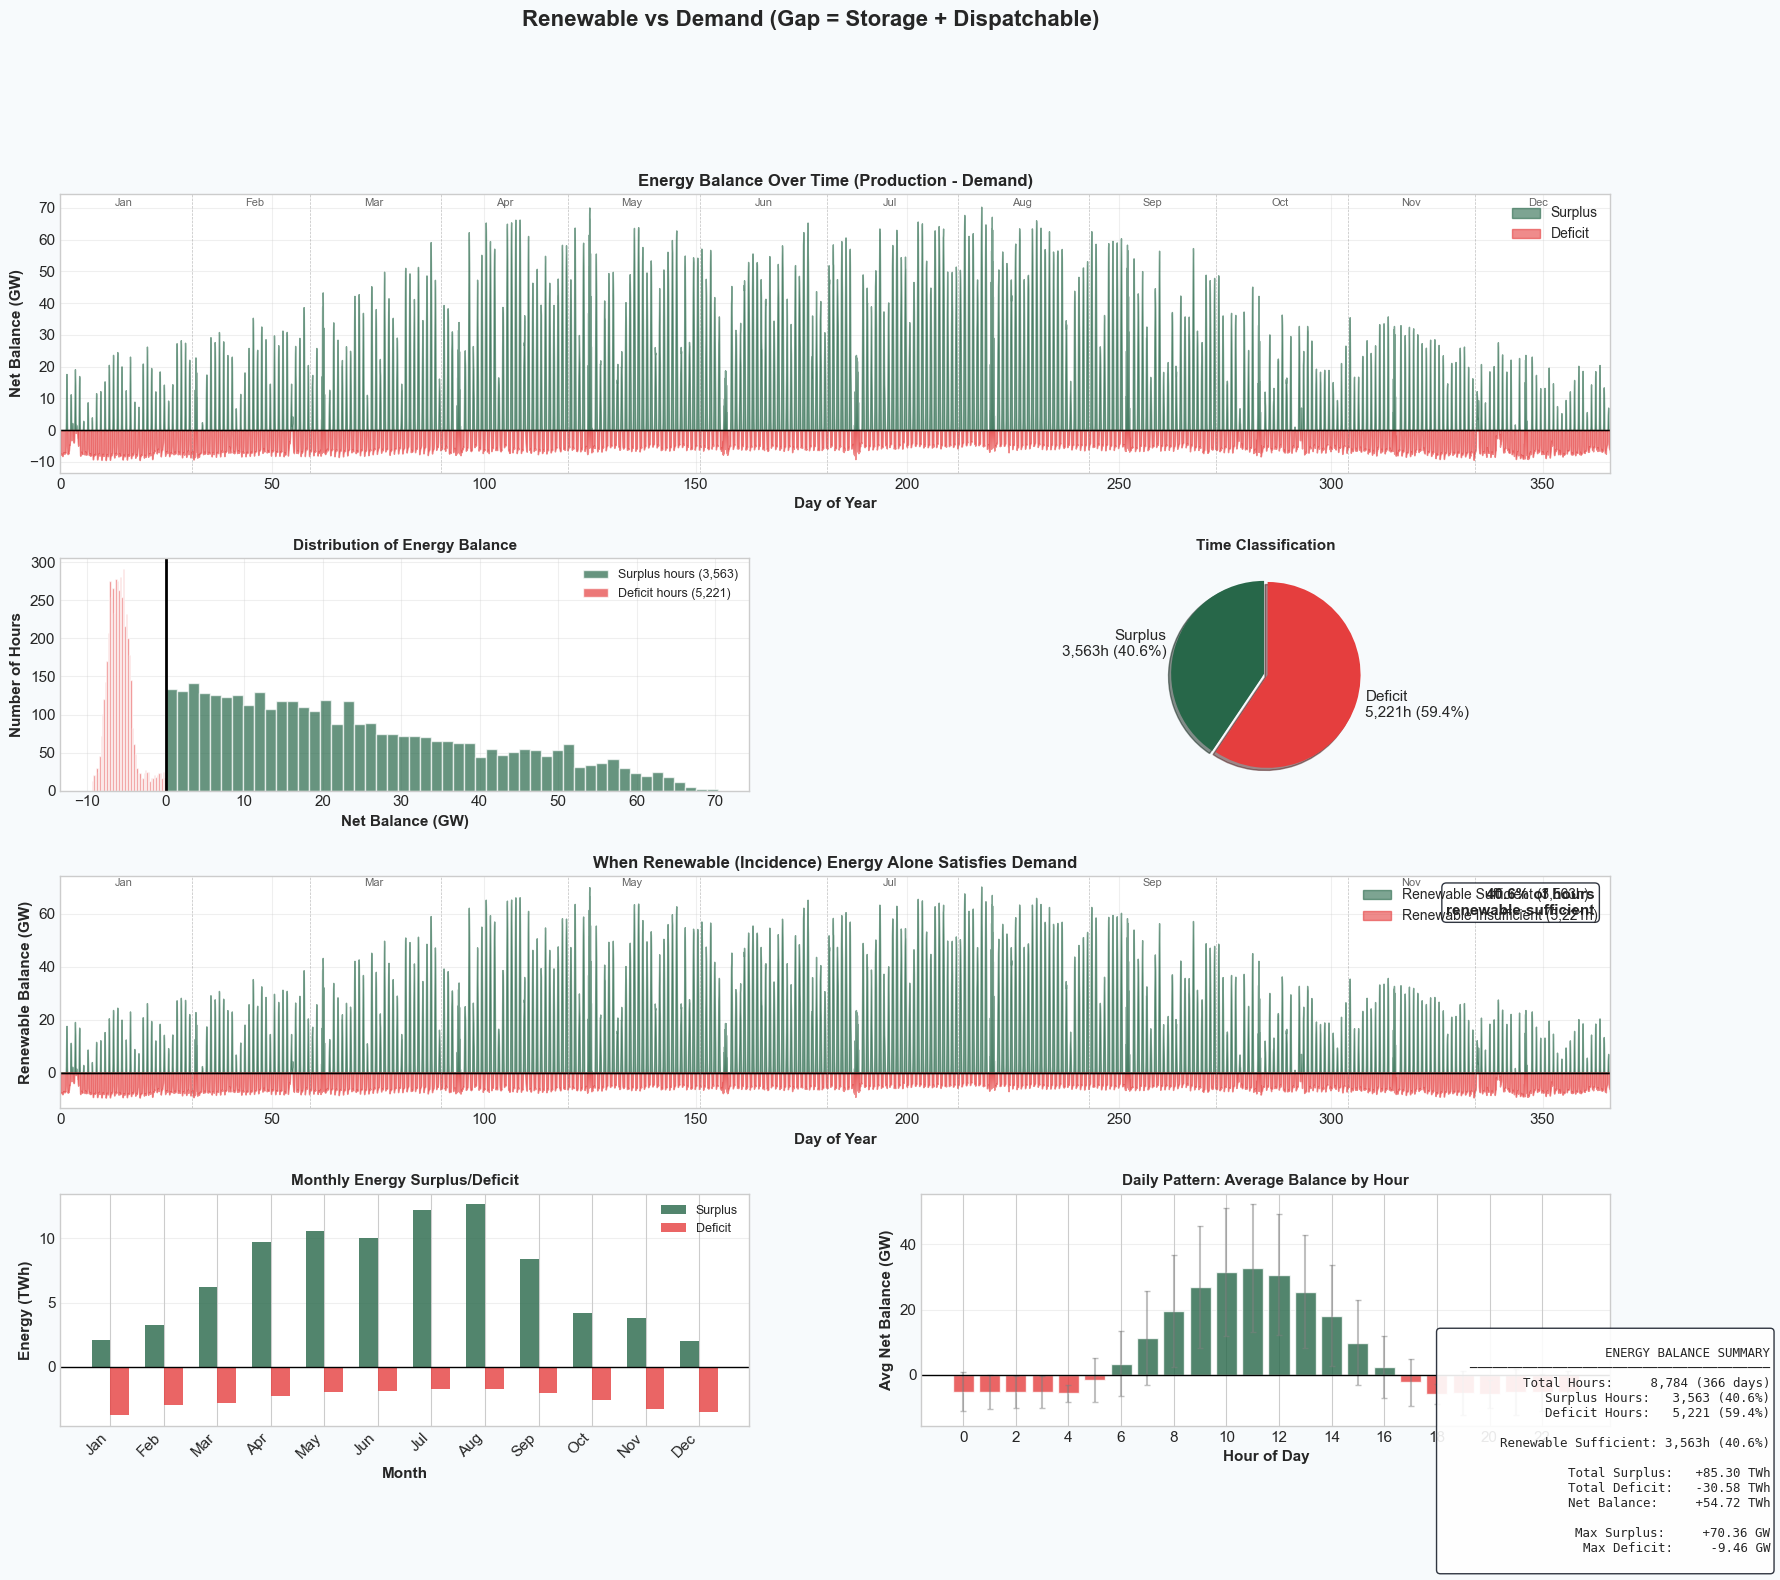

✅ Dispatch visualization complete!


In [5]:
# =============================================================================
# CREATE TEST PORTFOLIO AND RUN DISPATCH SIMULATION
# =============================================================================

# Example portfolio for testing (modify as needed)
# NOTE: BIO_OIL_ICE removed - Palm oil is the only imported bio-fuel
# ⚠️ CONSTRAINT: THERM must be ≥263 for aviation fuel compliance (23 TWh/year for 2024, 37 TWh/year for 2050)
test_portfolio = {
    # Renewable (incidence-based)
    'PV': 400, 'WD_ON': 50, 'WD_OFF': 50, 'HYD_R': 50, 'BIO_WOOD': 50,
    # Storage input (each PPU charges a specific storage)
    'PHS': 0,  # Charges Lake - set to 0 to test water inflow only
    'H2_G': 500, 'H2_GL': 500, 'H2_L': 500,  # Charge H2 storages
    'SYN_FT': 2000, 'SYN_CRACK': 2000,  # Charge Fuel Tank (aviation)
    'SYN_METH': 1000,  # Charges CH4 200bar
    'NH3_FULL': 700,  # Charges Ammonia
    'CH4_BIO': 500,  # Charges Biogas
    'SOL_SALT_STORE': 100,  # Charges Solar salt
    # Storage extraction (dispatchable)
    'HYD_S': 300, 'THERM': 1000, 'H2P_G': 100, 'H2P_L': 100,  # THERM ≥263 for aviation
    'THERM_CH4': 100, 'NH3_P': 100, 'IMP_BIOG': 100, 'PALM_ICE': 100,
    'SOL_SALT': 100, 'SOL_STEAM': 100,  # Extract from Solar salt
}

print("Test Portfolio Configuration:")
print("=" * 60)
total_units = sum(test_portfolio.values())
print(f"Total PPU units: {total_units}")
renewable = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
storage_in = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_CRACK', 'SYN_METH', 'NH3_FULL', 'CH4_BIO', 'SOL_SALT_STORE']
storage_out = ['HYD_S', 'THERM', 'H2P_G', 'H2P_L', 'THERM_CH4', 'NH3_P', 'IMP_BIOG', 'PALM_ICE', 'SOL_SALT', 'SOL_STEAM']
print(f"  Renewable: {sum(test_portfolio.get(p, 0) for p in renewable)} units")
print(f"  Storage Input: {sum(test_portfolio.get(p, 0) for p in storage_in)} units")
print(f"  Storage Extraction: {sum(test_portfolio.get(p, 0) for p in storage_out)} units")

# =========================================================================
# COMPLIANCE CHECK: Verify test portfolio meets ALL hard constraints
# =========================================================================
print("\n🔍 CONSTRAINT COMPLIANCE CHECK:")
print("-" * 60)

# 1. Aviation Fuel Constraint
MIN_THERM_FOR_AVIATION = 263
therm_count = test_portfolio.get('THERM', 0)
syn_ft_count = test_portfolio.get('SYN_FT', 0)
syn_crack_count = test_portfolio.get('SYN_CRACK', 0)

aviation_compliant = (
    therm_count >= MIN_THERM_FOR_AVIATION and 
    (syn_ft_count > 0 or syn_crack_count > 0)
)

if aviation_compliant:
    print(f"✅ Aviation Fuel: PASS")
    print(f"   - THERM: {therm_count} (≥{MIN_THERM_FOR_AVIATION} required)")
    print(f"   - SYN_FT: {syn_ft_count}, SYN_CRACK: {syn_crack_count}")
else:
    print(f"❌ Aviation Fuel: FAIL")
    print(f"   - THERM: {therm_count} (need ≥{MIN_THERM_FOR_AVIATION})")
    print(f"   - Synthetic fuel producers: SYN_FT={syn_ft_count}, SYN_CRACK={syn_crack_count}")
    print(f"   ⚠️  This portfolio will be penalized during optimization!")

# 2. Electrical Sovereignty (will be checked in dispatch simulation)
print(f"⏳ Electrical Sovereignty (≥{config.energy_system.TARGET_ANNUAL_DEMAND_TWH:.0f} TWh/year): Check after simulation")

# 3. Cyclic SOC (will be checked in dispatch simulation)
print(f"⏳ Cyclic SOC (storage returns to initial): Check after simulation")
print("-" * 60)

# =========================================================================
# RUN FULL-YEAR DISPATCH SIMULATION
# =========================================================================
print("\n⏳ Running full-year dispatch simulation (8,760 hours)...")
print("   This may take 30-60 seconds...")

portfolio = Portfolio(ppu_counts=test_portfolio)
individual = Individual(portfolio=portfolio)

full_year_results = evaluate_portfolio_full_year(
    individual=individual,
    config=config,
    verbose=False
)

print("✅ Simulation complete!")

# =========================================================================
# VISUALIZE DISPATCH RESULTS
# =========================================================================
print("\n📊 Generating visualizations...")

# Plot production by source
fig1 = plot_full_year_production_by_source(
    full_year_results,
    title="Hourly Production Stack vs Demand",
    save_path="data/result_plots/dispatch_production_stack.png"
)
plt.show()

# Plot storage state of charge
fig2 = plot_full_year_storage(
    full_year_results,
    title="Storage State of Charge - Full Year",
    save_path="data/result_plots/dispatch_storage_soc.png"
)
plt.show()

# Plot renewable vs demand balance
fig3 = plot_energy_balance_distribution(
    demand=full_year_results.demand,
    production=full_year_results.renewable_production,
    renewable_production=full_year_results.renewable_production,
    title="Renewable vs Demand (Gap = Storage + Dispatchable)",
    save_path="data/result_plots/dispatch_energy_balance.png"
)
plt.show()

print("✅ Dispatch visualization complete!")


## Section 2: Genetic Optimizer

### 2.1 Find Pareto Frontier


In [ ]:
# =============================================================================
# MULTI-OBJECTIVE GENETIC ALGORITHM: Find Pareto Frontier
# =============================================================================
# This section runs a genetic algorithm to find portfolios on the Pareto frontier
# optimizing for: Risk of Technology (RoT), Volatility, and Return

from multi_objective_explorer import ObjectiveConfig, get_objective_configs

# Use predefined objective configurations (optimizes across RoT, Volatility, Return)
objectives = get_objective_configs()

# GA Parameters (adjust based on available time)
N_GENERATIONS = 10  # Number of generations
POP_SIZE = 20       # Population size per generation

# Output path (scenario-specific)
if DEMAND_SCENARIO == "2050":
    OUTPUT_PATH = "data/result_plots/multi_objective_results_2050.csv"
else:
    OUTPUT_PATH = "data/result_plots/multi_objective_results.csv"

print("=" * 60)
print("RUNNING MULTI-OBJECTIVE GENETIC ALGORITHM")
print("=" * 60)
print(f"   Scenario: {DEMAND_SCENARIO}")
print(f"   Generations: {N_GENERATIONS}")
print(f"   Population Size: {POP_SIZE}")
print(f"   Objectives: {len(objectives)} (RoT, Volatility, Return)")
print(f"   Output: {OUTPUT_PATH}")
print()

# Run exploration (this can take 30-60 minutes)
all_results_df, pareto_df = explore_and_find_frontier(
    config=config,
    objectives=objectives,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    output_path=OUTPUT_PATH,
    verbose=True,
    use_existing_as_seeds=False
)

print("\n" + "=" * 60)
print(f"✅ Exploration complete!")
print(f"   Total portfolios: {len(all_results_df)}")
print(f"   Frontier portfolios: {len(pareto_df)}")
print(f"   Results saved to: {OUTPUT_PATH}")


### 2.2 Interpolate Along Frontier


In [ ]:
# =============================================================================
# FRONTIER RESEARCH: Systematic Exploration Along the Pareto Line
# =============================================================================
# This interpolates additional portfolios along the Pareto frontier to make it more exhaustive

from frontier_research import FrontierResearchConfig, run_frontier_research
from pareto_frontier import extract_pareto_frontier_3d_from_df
from pathlib import Path

# Load frontier portfolios
frontier_3d_path = OUTPUT_PATH.replace('.csv', '_frontier_3d.csv')

# First, extract 3D Pareto frontier if not already done
if not Path(frontier_3d_path).exists():
    print("📊 Extracting 3D Pareto frontier...")
    # Filter for compliant portfolios
    compliant_mask = all_results_df.apply(
        lambda row: notebook_helpers.is_portfolio_compliant(
            notebook_helpers.parse_portfolio_dict(row.get('portfolio_dict', {})), 
            row, config
        ), axis=1
    )
    compliant_df = all_results_df[compliant_mask].copy()
    
    frontier_3d_df = extract_pareto_frontier_3d_from_df(
        compliant_df,
        x_col='x_RoT',
        y_col='y_volatility',
        z_col='z_return',
        minimize_x=True,
        minimize_y=True,
        minimize_z=False  # Maximize return
    )
    frontier_3d_df.to_csv(frontier_3d_path, index=False)
    print(f"✅ 3D frontier saved to: {frontier_3d_path}")
else:
    frontier_3d_df = pd.read_csv(frontier_3d_path)
    print(f"✅ Loaded existing 3D frontier: {len(frontier_3d_df)} portfolios")

# Configure research parameters
research_config = FrontierResearchConfig(
    alphas=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    verbose=True,
    output_path=f'data/result_plots/extended_frontier_research_{DEMAND_SCENARIO}.csv'
)

# Wrapper functions for frontier research
def run_full_year_simulation(portfolio_counts, ppu_dictionary, demand_data, spot_data,
                              solar_data, wind_data, water_inflow_data, config, 
                              ppu_definitions, verbose=False):
    portfolio = Portfolio(ppu_counts=portfolio_counts)
    individual = Individual(portfolio=portfolio)
    return evaluate_portfolio_full_year(individual, config, verbose=verbose)

def calculate_portfolio_metrics(full_year_results, ppu_definitions, spot_data, 
                                  portfolio_counts, config):
    portfolio = Portfolio(ppu_counts=portfolio_counts)
    individual = Individual(portfolio=portfolio)
    risk_calculator = RiskCalculator(config)
    metrics = calculate_portfolio_metrics_3d(individual, config, risk_calculator, debug=False)
    
    class CompatibleMetrics:
        def __init__(self, m):
            self.risk_of_technology = m.x_rot
            self.volatility = m.y_volatility
            self.mean_return = m.z_return
            self.total_energy_twh = m.total_energy_twh
    return CompatibleMetrics(metrics)

# Create ppu_dictionary placeholder (ppu_definitions is already a dict from load_all_ppu_data)
ppu_dictionary = create_ppu_dictionary(
    Portfolio(ppu_counts={}),
    ppu_definitions,  # This is already a dict
    config
)

# Run frontier research
print("\n" + "=" * 60)
print("RUNNING FRONTIER RESEARCH (Interpolation)")
print("=" * 60)

frontier_results = run_frontier_research(
    frontier_path=frontier_3d_path,
    run_simulation_func=run_full_year_simulation,
    calculate_metrics_func=calculate_portfolio_metrics,
    ppu_dictionary=ppu_dictionary,
    demand_data=cached_data.get_demand(copy=False),
    spot_data=cached_data.get_spot_prices(copy=False),
    solar_data=cached_data.get_solar_incidence(copy=False),
    wind_data=cached_data.get_wind_incidence(copy=False),
    water_inflow_data=cached_data.get_water_inflow(copy=False),
    config=config,
    ppu_definitions=ppu_definitions,
    research_config=research_config
)

print("\n✅ Frontier research complete!")
print(f"   Extended results saved to: {research_config.output_path}")


## Section 3: Analysis

### 3.1 Portfolio Analysis


#### 3.1.1 3D Representation of Frontier


In [ ]:
# =============================================================================
# 3D INTERACTIVE FRONTIER VISUALIZATION
# =============================================================================
import plotly.graph_objects as go
from scipy.spatial import ConvexHull

# Get file paths
all_path, frontier_path = notebook_helpers.get_frontier_file_paths(DEMAND_SCENARIO)

if not frontier_path.exists():
    print(f"⚠️ Frontier file not found: {frontier_path}")
    print("   Please run Section 2.1 first to generate the frontier.")
else:
    all_df_raw = pd.read_csv(all_path)
    frontier_df_raw = pd.read_csv(frontier_path)
    
    # Filter for compliant portfolios
    all_compliant = all_df_raw.apply(
        lambda row: notebook_helpers.is_portfolio_compliant(
            notebook_helpers.parse_portfolio_dict(row.get('portfolio_dict', {})), 
            row, config
        ), axis=1
    )
    frontier_compliant = frontier_df_raw.apply(
        lambda row: notebook_helpers.is_portfolio_compliant(
            notebook_helpers.parse_portfolio_dict(row.get('portfolio_dict', {})), 
            row, config
        ), axis=1
    )
    
    all_df = all_df_raw[all_compliant].copy()
    frontier_df = frontier_df_raw[frontier_compliant].copy()
    
    print(f"📊 Loaded portfolios (compliance filtering):")
    print(f"   All: {len(all_df)} / {len(all_df_raw)} ({100*len(all_df)/len(all_df_raw):.1f}%)")
    print(f"   Frontier: {len(frontier_df)} / {len(frontier_df_raw)} ({100*len(frontier_df)/len(frontier_df_raw):.1f}%)")
    
    def create_frontier_mesh(frontier_df):
        """Create convex hull mesh for frontier shape."""
        pts = frontier_df[['y_volatility', 'x_RoT', 'z_return']].values
        if len(pts) < 4:
            return None
        try:
            hull = ConvexHull(pts)
            return go.Mesh3d(
                x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
                i=hull.simplices[:, 0], j=hull.simplices[:, 1], k=hull.simplices[:, 2],
                opacity=0.25, color='steelblue', name='Frontier Hull'
            )
        except:
            return None
    
    def plot_3d_frontier(view='Frontier Only'):
        """Interactive 3D scatter plot with toggle."""
        fig = go.Figure()
        
        if view == 'All Portfolios':
            fig.add_trace(go.Scatter3d(
                x=all_df['y_volatility'], y=all_df['x_RoT'], z=all_df['z_return'],
                mode='markers',
                marker=dict(size=3, color=all_df['z_return'], colorscale='RdYlGn', opacity=0.4),
                name=f'All ({len(all_df)})',
                hovertemplate='Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Ret: %{z:.2f}%<extra></extra>'
            ))
        
        fig.add_trace(go.Scatter3d(
            x=frontier_df['y_volatility'], y=frontier_df['x_RoT'], z=frontier_df['z_return'],
            mode='markers',
            marker=dict(size=7, color=frontier_df['z_return'], colorscale='RdYlGn',
                       line=dict(width=1, color='black'), opacity=1.0,
                       colorbar=dict(title='Return %', x=1.02) if view != 'All Portfolios' else None),
            name=f'Frontier ({len(frontier_df)})',
            hovertemplate='<b>Frontier</b><br>Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Ret: %{z:.2f}%<extra></extra>'
        ))
        
        mesh = create_frontier_mesh(frontier_df)
        if mesh:
            fig.add_trace(mesh)
        
        # Corner portfolios
        corners = {
            'Best Return': frontier_df.loc[frontier_df['z_return'].idxmax()],
            'Lowest RoT': frontier_df.loc[frontier_df['x_RoT'].idxmin()],
            'Lowest Vol': frontier_df.loc[frontier_df['y_volatility'].idxmin()]
        }
        for name, row in corners.items():
            fig.add_trace(go.Scatter3d(
                x=[row['y_volatility']], y=[row['x_RoT']], z=[row['z_return']],
                mode='markers+text', text=[name], textposition='top center',
                marker=dict(size=10, symbol='diamond', color='gold', line=dict(width=2, color='black')),
                name=name, showlegend=True
            ))
        
        fig.update_layout(
            title=dict(text=f'<b>3D Pareto Frontier ({DEMAND_SCENARIO})</b> ({view})', x=0.5),
            scene=dict(
                xaxis=dict(title='Volatility (CHF/MWh)'),
                yaxis=dict(title='Risk of Technology'),
                zaxis=dict(title='Return (%)'),
                camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))
            ),
            legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)'),
            margin=dict(l=0, r=0, t=50, b=0),
            height=650
        )
        fig.show()
    
    if HAS_WIDGETS:
        from ipywidgets import interact
        interact(plot_3d_frontier, view=Dropdown(
            options=['Frontier Only', 'All Portfolios'],
            value='Frontier Only',
            description='View:'
        ))
    else:
        plot_3d_frontier('Frontier Only')


#### 3.1.2 Efficiency & Economy Analysis of All Frontier Portfolios


In [ ]:
# =============================================================================
# COMPREHENSIVE EFFICIENCY ANALYSIS: Full Simulation of All Frontier Portfolios
# =============================================================================
# This runs full-year simulations for all frontier portfolios to calculate
# TRUE efficiency metrics (not available from CSV data alone)

import time
from tqdm import tqdm
from pathlib import Path

# Get frontier file path
_, frontier_path = notebook_helpers.get_frontier_file_paths(DEMAND_SCENARIO)

if not frontier_path.exists():
    print(f"⚠️ Frontier file not found: {frontier_path}")
    print("   Please run Section 2.1 first to generate the frontier.")
else:
    frontier_df = pd.read_csv(frontier_path)
    print(f"✅ Loaded {len(frontier_df)} frontier portfolios")
    print(f"⏳ Running full-year simulations for efficiency analysis...")
    print(f"   Estimated time: {len(frontier_df) * 5 / 60:.1f} - {len(frontier_df) * 15 / 60:.1f} minutes")
    print()
    
    efficiency_results = []
    start_time = time.time()
    
    # Process each portfolio with progress bar
    for idx, row in tqdm(frontier_df.iterrows(), total=len(frontier_df), desc="Simulating portfolios"):
        try:
            portfolio_dict = notebook_helpers.parse_portfolio_dict(row.get('portfolio_dict', {}))
            if not portfolio_dict:
                continue
            
            portfolio = Portfolio(ppu_counts=portfolio_dict)
            individual = Individual(portfolio=portfolio)
            
            # Run full-year simulation
            full_year_results = evaluate_portfolio_full_year(
                individual=individual,
                config=config,
                verbose=False
            )
            
            # Calculate energy flows
            energy_flows = notebook_helpers.calculate_energy_flows(
                full_year_results, portfolio_dict, config
            )
            
            # Store results
            efficiency_results.append({
                'portfolio_idx': idx,
                'x_RoT': row['x_RoT'],
                'y_volatility': row['y_volatility'],
                'z_return': row['z_return'],
                **energy_flows
            })
            
        except Exception as e:
            print(f"\n⚠️  Error processing portfolio {idx}: {e}")
            continue
    
    elapsed_time = time.time() - start_time
    
    print(f"\n✅ Simulations complete!")
    print(f"   Time elapsed: {elapsed_time/60:.1f} minutes")
    print(f"   Successful simulations: {len(efficiency_results)}/{len(frontier_df)}")
    
    if len(efficiency_results) > 0:
        # Create results DataFrame
        eff_df = pd.DataFrame(efficiency_results)
        
        # Save results
        output_path = Path(f"data/result_plots/frontier_efficiency_analysis_{DEMAND_SCENARIO}.csv")
        eff_df.to_csv(output_path, index=False)
        print(f"   Results saved to: {output_path}")
        
        # Print statistics
        print("\n" + "="*80)
        print("EFFICIENCY STATISTICS")
        print("="*80)
        
        print(f"\n📊 Overall Efficiency (Raw Incidence → Final Demand):")
        print(f"   Mean:     {eff_df['overall_efficiency'].mean():.2f}%")
        print(f"   Median:   {eff_df['overall_efficiency'].median():.2f}%")
        print(f"   Std Dev:  {eff_df['overall_efficiency'].std():.2f}%")
        print(f"   Min:      {eff_df['overall_efficiency'].min():.2f}%")
        print(f"   Max:      {eff_df['overall_efficiency'].max():.2f}%")
        
        print(f"\n📉 Energy Losses Breakdown (Average):")
        print(f"   Production Losses:     {eff_df['production_losses_twh'].mean():.2f} TWh")
        print(f"   Storage Losses:        {eff_df['storage_losses_twh'].mean():.2f} TWh")
        print(f"   Flexible Production Losses: {eff_df['flexible_losses_twh'].mean():.2f} TWh")
        print(f"   Curtailment/Other:     {eff_df['renewable_curtailed_twh'].mean():.2f} TWh")
        
        # Visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Efficiency vs objectives
        ax1 = axes[0, 0]
        scatter1 = ax1.scatter(eff_df['x_RoT'], eff_df['overall_efficiency'], 
                               c=eff_df['z_return'], cmap='RdYlGn', alpha=0.7, s=60)
        ax1.set_xlabel('Risk of Technology (RoT)', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Overall Efficiency (%)', fontsize=11, fontweight='bold')
        ax1.set_title('Efficiency vs RoT', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        plt.colorbar(scatter1, ax=ax1, label='Return (%)')
        
        ax2 = axes[0, 1]
        scatter2 = ax2.scatter(eff_df['y_volatility'], eff_df['overall_efficiency'],
                               c=eff_df['z_return'], cmap='RdYlGn', alpha=0.7, s=60)
        ax2.set_xlabel('Volatility (CHF/MWh)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Overall Efficiency (%)', fontsize=11, fontweight='bold')
        ax2.set_title('Efficiency vs Volatility', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        plt.colorbar(scatter2, ax=ax2, label='Return (%)')
        
        ax3 = axes[0, 2]
        scatter3 = ax3.scatter(eff_df['z_return'], eff_df['overall_efficiency'],
                               c=eff_df['x_RoT'], cmap='viridis', alpha=0.7, s=60)
        ax3.set_xlabel('Return (%)', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Overall Efficiency (%)', fontsize=11, fontweight='bold')
        ax3.set_title('Efficiency vs Return', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        plt.colorbar(scatter3, ax=ax3, label='RoT')
        
        # Storage RT Efficiency distribution
        ax4 = axes[1, 0]
        valid_storage = eff_df[eff_df['storage_charged_twh'] > 0]
        if len(valid_storage) > 0:
            ax4.hist(valid_storage['storage_rt_efficiency'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
            ax4.axvline(valid_storage['storage_rt_efficiency'].mean(), color='red', linestyle='--', 
                       linewidth=2, label=f"Mean: {valid_storage['storage_rt_efficiency'].mean():.1f}%")
            ax4.set_xlabel('Storage Round-Trip Efficiency (%)', fontsize=11, fontweight='bold')
            ax4.set_ylabel('Number of Portfolios', fontsize=11, fontweight='bold')
            ax4.set_title('Storage Round-Trip Efficiency Distribution', fontsize=12, fontweight='bold')
            ax4.legend()
            ax4.grid(True, alpha=0.3, axis='y')
        
        # Renewable Utilization distribution
        ax5 = axes[1, 1]
        ax5.hist(eff_df['renewable_utilization'], bins=20, alpha=0.7, color='green', edgecolor='black')
        ax5.axvline(eff_df['renewable_utilization'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {eff_df['renewable_utilization'].mean():.1f}%")
        ax5.set_xlabel('Renewable Utilization (%)', fontsize=11, fontweight='bold')
        ax5.set_ylabel('Number of Portfolios', fontsize=11, fontweight='bold')
        ax5.set_title('Renewable Utilization Distribution', fontsize=12, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3, axis='y')
        
        # Efficiency distribution
        ax6 = axes[1, 2]
        ax6.hist(eff_df['overall_efficiency'], bins=20, alpha=0.7, color='orange', edgecolor='black')
        ax6.axvline(eff_df['overall_efficiency'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {eff_df['overall_efficiency'].mean():.1f}%")
        ax6.set_xlabel('Overall Efficiency (%)', fontsize=11, fontweight='bold')
        ax6.set_ylabel('Number of Portfolios', fontsize=11, fontweight='bold')
        ax6.set_title('Overall Efficiency Distribution', fontsize=12, fontweight='bold')
        ax6.legend()
        ax6.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(f'data/result_plots/frontier_efficiency_analysis_{DEMAND_SCENARIO}.png', dpi=150, bbox_inches='tight')
        print(f"\n✅ Visualization saved to: data/result_plots/frontier_efficiency_analysis_{DEMAND_SCENARIO}.png")
        plt.show()
    else:
        print("\n❌ No successful simulations. Check for errors above.")


### 3.2 Individual Portfolio Analysis

#### 3.2.1 Dispatch Simulation Results (Same as Section 1.1)


In [ ]:
# =============================================================================
# INTERACTIVE PORTFOLIO ANALYSIS: Select Portfolio from Frontier
# =============================================================================
# This section allows you to select a portfolio from the frontier and analyze it
# in detail, including dispatch simulation and efficiency analysis

import time
from IPython.display import clear_output, display

# Get frontier file path
_, frontier_path = notebook_helpers.get_frontier_file_paths(DEMAND_SCENARIO)

if not frontier_path.exists():
    print(f"⚠️ Frontier file not found: {frontier_path}")
    print("   Please run Section 2.1 first to generate the frontier.")
else:
    frontier_df_raw = pd.read_csv(frontier_path)
    
    # Filter for compliant portfolios
    print("🔍 Filtering for compliant portfolios...")
    compliant_mask = frontier_df_raw.apply(
        lambda row: notebook_helpers.is_portfolio_compliant(
            notebook_helpers.parse_portfolio_dict(row.get('portfolio_dict', {})), 
            row, config
        ), axis=1
    )
    frontier_df = frontier_df_raw[compliant_mask].copy().reset_index(drop=True)
    
    print(f"   Total frontier portfolios: {len(frontier_df_raw)}")
    print(f"   ✅ Compliant portfolios: {len(frontier_df)}")
    
    if len(frontier_df) == 0:
        print("\n⚠️ WARNING: No compliant portfolios found in frontier!")
    else:
        # Create dropdown options
        portfolio_options = {}
        for idx, row in frontier_df.iterrows():
            label = f"#{int(idx)+1}: RoT={row['x_RoT']:.4f}, Vol={row['y_volatility']:.1f}, Ret={row['z_return']:.1f}%"
            portfolio_options[label] = int(idx)
        
        # Create widgets
        if HAS_WIDGETS:
            portfolio_dropdown = Dropdown(
                options=list(portfolio_options.keys()),
                value=list(portfolio_options.keys())[0],
                description='Portfolio:',
                style={'description_width': '80px'},
                layout=Layout(width='600px')
            )
            
            run_button = Button(
                description='🚀 Run Analysis',
                button_style='success',
                layout=Layout(width='150px', height='35px')
            )
            
            output_area = Output(layout=Layout(height='1000px', overflow='auto'))
            
            def run_portfolio_analysis(b):
                """Run full analysis for selected portfolio."""
                with output_area:
                    clear_output(wait=True)
                    
                    # Get selected portfolio
                    selected_idx = portfolio_options[portfolio_dropdown.value]
                    row = frontier_df.iloc[selected_idx]
                    
                    print("=" * 70)
                    print(f"ANALYZING PORTFOLIO #{selected_idx + 1}")
                    print("=" * 70)
                    print(f"  RoT:        {row['x_RoT']:.4f}")
                    print(f"  Volatility: {row['y_volatility']:.2f} CHF/MWh")
                    print(f"  Return:     {row['z_return']:.2f}%")
                    
                    # Parse portfolio dict
                    portfolio_dict = notebook_helpers.parse_portfolio_dict(row['portfolio_dict'])
                    
                    print(f"\n📦 Portfolio composition:")
                    for ppu, count in sorted(portfolio_dict.items(), key=lambda x: -x[1]):
                        if count > 0:
                            print(f"    {ppu}: {count} units")
                    
                    # Run full year simulation
                    print("\n⏳ Running full-year simulation (8,760 hours)...")
                    individual = Individual(portfolio=Portfolio(ppu_counts=portfolio_dict))
                    
                    start_time = time.time()
                    full_year_results = evaluate_portfolio_full_year(
                        individual=individual,
                        config=config,
                        verbose=False
                    )
                    elapsed = time.time() - start_time
                    print(f"✅ Simulation complete in {elapsed:.1f}s")
                    
                    # ================================================================
                    # DISPATCH VISUALIZATIONS (Same as Section 1.1)
                    # ================================================================
                    print("\n" + "=" * 70)
                    print("DISPATCH RESULTS")
                    print("=" * 70)
                    
                    plot_full_year_production_by_source(
                        full_year_results,
                        title=f"Portfolio #{selected_idx+1}: Hourly Production Stack vs Demand"
                    )
                    plt.show()
                    
                    plot_full_year_storage(
                        full_year_results,
                        title=f"Portfolio #{selected_idx+1}: Storage State of Charge - Full Year"
                    )
                    plt.show()
                    
                    plot_energy_balance_distribution(
                        demand=full_year_results.demand,
                        production=full_year_results.renewable_production,
                        renewable_production=full_year_results.renewable_production,
                        title=f"Portfolio #{selected_idx+1}: Renewable vs Demand"
                    )
                    plt.show()
            
            # Connect button
            run_button.on_click(run_portfolio_analysis)
            
            # Display widgets
            display(VBox([
                Label("Select a portfolio from the Pareto frontier:"),
                HBox([portfolio_dropdown, run_button]),
                output_area
            ]))
        else:
            print("⚠️ ipywidgets not available. Please install: pip install ipywidgets")
            print("\nTo analyze a portfolio manually, use:")
            print("  portfolio_dict = notebook_helpers.parse_portfolio_dict(frontier_df.iloc[0]['portfolio_dict'])")
            print("  individual = Individual(portfolio=Portfolio(ppu_counts=portfolio_dict))")
            print("  full_year_results = evaluate_portfolio_full_year(individual, config, verbose=False)")


#### 3.2.2 Efficiency Analysis of Particular Portfolio


In [ ]:
# =============================================================================
# EFFICIENCY ANALYSIS FOR SELECTED PORTFOLIO
# =============================================================================
# This calculates comprehensive energy flows and efficiency metrics for a single portfolio

# NOTE: This should be run after Section 3.2.1 to use the same full_year_results
# For demonstration, we'll use the first portfolio from the frontier

_, frontier_path = notebook_helpers.get_frontier_file_paths(DEMAND_SCENARIO)

if not frontier_path.exists():
    print(f"⚠️ Frontier file not found: {frontier_path}")
    print("   Please run Section 2.1 first to generate the frontier.")
else:
    frontier_df = pd.read_csv(frontier_path)
    
    # Filter for compliant portfolios
    compliant_mask = frontier_df.apply(
        lambda row: notebook_helpers.is_portfolio_compliant(
            notebook_helpers.parse_portfolio_dict(row.get('portfolio_dict', {})), 
            row, config
        ), axis=1
    )
    frontier_df = frontier_df[compliant_mask].copy().reset_index(drop=True)
    
    if len(frontier_df) == 0:
        print("⚠️ No compliant portfolios found.")
    else:
        # Select first portfolio (or modify index to select different one)
        selected_idx = 0
        row = frontier_df.iloc[selected_idx]
        portfolio_dict = notebook_helpers.parse_portfolio_dict(row['portfolio_dict'])
        
        print("=" * 70)
        print(f"EFFICIENCY ANALYSIS FOR PORTFOLIO #{selected_idx + 1}")
        print("=" * 70)
        print(f"  RoT: {row['x_RoT']:.4f}, Vol: {row['y_volatility']:.2f}, Ret: {row['z_return']:.2f}%")
        print()
        
        # Run simulation
        print("⏳ Running simulation...")
        individual = Individual(portfolio=Portfolio(ppu_counts=portfolio_dict))
        full_year_results = evaluate_portfolio_full_year(individual, config, verbose=False)
        
        # Calculate energy flows
        energy_flows = notebook_helpers.calculate_energy_flows(
            full_year_results, portfolio_dict, config
        )
        
        # Print detailed energy flow summary
        print("\n📊 ENERGY FLOW SUMMARY (From Raw Incidence to Final Demand):")
        print(f"   {'Metric':<45} | {'Value (TWh)':>15} | {'% of Raw Incidence':>18}")
        print(f"   {'-'*45}-+-{'-'*15}-+-{'-'*18}")
        
        raw_inc = energy_flows['raw_incidence_twh']
        print(f"   {'Raw Incidence Energy':<45} | {raw_inc:>15.2f} | {'100.0':>18}%")
        print(f"   {'  → After Production Conversion':<45} | {energy_flows['renewable_production_twh']:>15.2f} | {energy_flows['renewable_production_twh']/raw_inc*100 if raw_inc > 0 else 0:>17.1f}%")
        print(f"   {'    → Direct to Demand':<45} | {energy_flows['renewable_production_twh'] - energy_flows['storage_charged_twh']:>15.2f} | {(energy_flows['renewable_production_twh'] - energy_flows['storage_charged_twh'])/raw_inc*100 if raw_inc > 0 else 0:>17.1f}%")
        print(f"   {'    → Storage Charged':<45} | {energy_flows['storage_charged_twh']:>15.2f} | {energy_flows['storage_charged_twh']/raw_inc*100 if raw_inc > 0 else 0:>17.1f}%")
        print(f"   {'      → Storage Discharged':<45} | {energy_flows['storage_discharged_twh']:>15.2f} | {energy_flows['storage_discharged_twh']/raw_inc*100 if raw_inc > 0 else 0:>17.1f}%")
        print(f"   {'FINAL ENERGY DELIVERED (Demand)':<45} | {energy_flows['energy_delivered_twh']:>15.2f} | {energy_flows['energy_delivered_twh']/raw_inc*100 if raw_inc > 0 else 0:>17.1f}%")
        
        print(f"\n📉 ENERGY LOSSES BREAKDOWN:")
        print(f"   {'Loss Category':<45} | {'Value (TWh)':>15} | {'% of Raw Incidence':>18}")
        print(f"   {'-'*45}-+-{'-'*15}-+-{'-'*18}")
        print(f"   {'Production Losses (conversion)':<45} | {energy_flows['production_losses_twh']:>15.2f} | {energy_flows['production_losses_twh']/raw_inc*100 if raw_inc > 0 else 0:>17.1f}%")
        print(f"   {'Storage Losses (round-trip)':<45} | {energy_flows['storage_losses_twh']:>15.2f} | {energy_flows['storage_losses_twh']/raw_inc*100 if raw_inc > 0 else 0:>17.1f}%")
        print(f"   {'Flexible Production Losses':<45} | {energy_flows['flexible_losses_twh']:>15.2f} | {energy_flows['flexible_losses_twh']/raw_inc*100 if raw_inc > 0 else 0:>17.1f}%")
        print(f"   {'Curtailment/Other Losses':<45} | {energy_flows['renewable_curtailed_twh']:>15.2f} | {energy_flows['renewable_curtailed_twh']/raw_inc*100 if raw_inc > 0 else 0:>17.1f}%")
        print(f"   {'TOTAL LOSSES':<45} | {energy_flows['total_losses_twh']:>15.2f} | {energy_flows['total_losses_twh']/raw_inc*100 if raw_inc > 0 else 0:>17.1f}%")
        
        print(f"\n⚡ EFFECTIVENESS METRICS:")
        print(f"   {'Metric':<50} | {'Value':>10}")
        print(f"   {'-'*50}-+-{'-'*10}")
        print(f"   {'Overall System Efficiency (Raw → Delivered)':<50} | {energy_flows['overall_efficiency']:>9.2f}%")
        print(f"   {'Renewable Utilization (% of demand)':<50} | {energy_flows['renewable_utilization']:>9.2f}%")
        print(f"   {'Storage Utilization (% of renewable)':<50} | {energy_flows['storage_utilization']:>9.2f}%")
        print(f"   {'Storage Round-Trip Efficiency':<50} | {energy_flows['storage_rt_efficiency']:>9.2f}%")
        print(f"   {'Flexible Production Efficiency':<50} | {energy_flows['flexible_efficiency']:>9.2f}%")
        
        # Create visualization
        fig_eff, axes_eff = plt.subplots(1, 2, figsize=(16, 8))
        
        # Pie chart: Energy breakdown
        ax1 = axes_eff[0]
        pie_data = {
            'Energy Delivered': energy_flows['energy_delivered_twh'],
            'Production Losses': energy_flows['production_losses_twh'],
            'Storage Losses': energy_flows['storage_losses_twh'],
            'Flexible Production Losses': energy_flows['flexible_losses_twh'],
            'Curtailment/Other': energy_flows['renewable_curtailed_twh']
        }
        pie_data = {k: max(0, v) for k, v in pie_data.items() if v > 0.01}
        
        if pie_data:
            colors_pie = ['#2ecc71', '#e67e22', '#3498db', '#9b59b6', '#95a5a6']
            wedges, texts, autotexts = ax1.pie(
                list(pie_data.values()),
                labels=list(pie_data.keys()),
                autopct=lambda pct: f'{pct:.1f}%\n({pct*raw_inc/100:.1f} TWh)',
                colors=colors_pie[:len(pie_data)],
                startangle=90,
                textprops={'fontsize': 10, 'fontweight': 'bold'}
            )
            ax1.set_title('Energy Breakdown: Delivered vs Losses\n(From Raw Incidence)', 
                         fontsize=14, fontweight='bold')
        
        # Bar chart: Loss breakdown
        ax2 = axes_eff[1]
        loss_categories = ['Production\nLosses', 'Storage\nLosses', 'Flexible\nLosses', 'Curtailment']
        loss_values = [energy_flows['production_losses_twh'], energy_flows['storage_losses_twh'], 
                      energy_flows['flexible_losses_twh'], energy_flows['renewable_curtailed_twh']]
        loss_colors = ['#e67e22', '#3498db', '#9b59b6', '#95a5a6']
        
        bars = ax2.bar(loss_categories, loss_values, color=loss_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Energy Losses (TWh)', fontsize=12, fontweight='bold')
        ax2.set_title('Energy Losses Breakdown by Category', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        for bar, val in zip(bars, loss_values):
            if val > 0.01:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{val:.1f} TWh\n({val/raw_inc*100:.1f}%)',
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\n✅ Efficiency analysis complete!")
